description

In [35]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
print_figs = True



In [29]:
# model specs


parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=30, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-accel', action='store_true', 
                    help='disables accelerator')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args, _ = parser.parse_known_args()


torch.manual_seed(args.seed)


# Decide which device we want to run on (CUDA > MPS > CPU)
if torch.cuda.is_available() and ngpu > 0:
    device = torch.device("cuda:0")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

kwargs = {'num_workers': 1, 'pin_memory': True} if device.type in ["cuda", "mps"] else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../../datasets', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../../datasets', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=False, **kwargs)





Using device: mps


In [30]:
# class

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [31]:
# functions

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    avg_loss = train_loss / len(train_loader.dataset)

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return avg_loss  


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         '../../../datasets/results/VAE_MNIST/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [32]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
train_losses = []


for epoch in range(1, args.epochs + 1):
    avg_loss = train(epoch)
    train_losses.append(avg_loss)

    test(epoch)

    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                    '../../../datasets/results/VAE_MNIST/sample_' + str(epoch) + '.png')





Train Epoch: 1 [0/60000 (0%)]	Loss: 550.815796
Train Epoch: 1 [1280/60000 (2%)]	Loss: 306.415344
Train Epoch: 1 [2560/60000 (4%)]	Loss: 238.970428
Train Epoch: 1 [3840/60000 (6%)]	Loss: 219.622406
Train Epoch: 1 [5120/60000 (9%)]	Loss: 214.331833
Train Epoch: 1 [6400/60000 (11%)]	Loss: 208.944855
Train Epoch: 1 [7680/60000 (13%)]	Loss: 206.190445
Train Epoch: 1 [8960/60000 (15%)]	Loss: 195.811539
Train Epoch: 1 [10240/60000 (17%)]	Loss: 196.140961
Train Epoch: 1 [11520/60000 (19%)]	Loss: 193.512360
Train Epoch: 1 [12800/60000 (21%)]	Loss: 182.127335
Train Epoch: 1 [14080/60000 (23%)]	Loss: 176.475739
Train Epoch: 1 [15360/60000 (26%)]	Loss: 185.079376
Train Epoch: 1 [16640/60000 (28%)]	Loss: 170.465424
Train Epoch: 1 [17920/60000 (30%)]	Loss: 168.447723
Train Epoch: 1 [19200/60000 (32%)]	Loss: 163.081894
Train Epoch: 1 [20480/60000 (34%)]	Loss: 163.014450
Train Epoch: 1 [21760/60000 (36%)]	Loss: 152.732758
Train Epoch: 1 [23040/60000 (38%)]	Loss: 158.169296
Train Epoch: 1 [24320/60000 

In [38]:
# store final sample
save_image(sample.view(64, 1, 28, 28),
                    '../img/week6_VAE_MNIST_sample' + '.png')

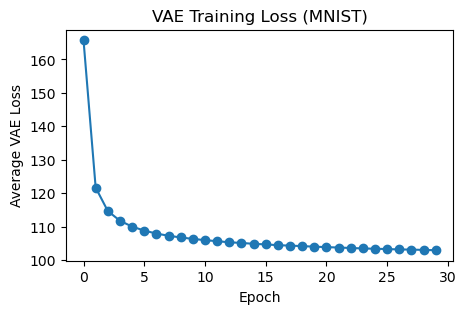

In [36]:
plt.figure(figsize=(5,3))
plt.plot(train_losses, '-o')
plt.xlabel("Epoch")
plt.ylabel("Average VAE Loss")
plt.title("VAE Training Loss (MNIST)")
    

if print_figs:
    plt.savefig("../img/week6_MNIST_VAE.pdf", format="pdf", bbox_inches="tight")
    
    